# Experiments with torchfm, which has a range of models based on FM (Factorization Machines). 
* None of these models are sequence-aware.
* Anaconda context must be set to "base". Eventually work with poetry.
* Try working with wandb (Weights & Biases)
* Starting with my_fm_copy.ipynb on July 21, 2021, integrate with elements of the code I wrote for rankfm. Specifically, I will read the data with the newlib.py library. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchfm
from torchfm import layer as fm_layer, model as fm_model
from torchfm.model import fm, lr, nfm, wd
import torch.nn.functional as F
import pandas as pd
import pandas_options
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
tt = torch.tensor
import numpy as np
# import tqdm
import random
import matplotlib.pyplot as plt
import myfunclib as myfm
import d2l_torch as d2l
import datalib
import wandb

In [440]:
from fastcore.all import L, AttrDict

In [446]:
#wandb.init(project="my-test-project")

wandb: Currently logged in as: erlebacher. Use `wandb login --relogin` to force relogin


In [6]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 128
}

wandb.log({"loss": loss})

# Optional
wandb.watch(model)

NameError: name 'loss' is not defined

In [4]:
device = d2l.try_gpu()
print(device)

cuda:0


In [5]:
gdct = {
    'device': device,  # 'cpu'
    'embed_dim': 10,
    'nb_epochs': 100,
    'lr': 0.05,
    'wd': 1.e-5,
    'optim': 'adamW',
    'batch_size' : 4096
}

In [6]:
gdct['device'] = 'cpu'

In [534]:
%%time 
in_file = "activity_reduced_with_attributes.csv"
dct = datalib.read_data_attributes_single_file(in_file, dct=AttrDict(), continuous_attrib=True)
dct.keys()

df_item_attrib columns:  ['D', 'avg_yr_l', 'avg_yr_h', 'IATA', 'LAT_DEC', 'LON_DEC', 'HEIGHT']
df_item_attrib shape:  (94, 7)
CPU times: user 261 ms, sys: 11.9 ms, total: 273 ms
Wall time: 272 ms


dict_keys(['age_cuts', 'df_members', 'df_with_attrib', 'field_types', 'field_dims'])

In [535]:
def convert_cat_variables(dct):
    idx2member, member2idx = datalib.cat2dict(dct['df_with_attrib']['MEMBER_ID'])
    idx2dest, dest2idx = datalib.cat2dict(dct['df_with_attrib']['D'])
    idx2gender, gender2idx = datalib.cat2dict(dct.df_with_attrib.GENDER)
    # print(idx2gender)
    # print(gender2idx)
    # print(idx2dest)
    # print(dest2idx)
    df1 = dct['df_with_attrib'].copy()
    df1['MEMBER_ID'] = df1['MEMBER_ID'].map(member2idx)
    df1['D'] = df1['D'].map(dest2idx)
    df1['GENDER'] = df1.GENDER.map(gender2idx)
    return df1

In [536]:
df1 = convert_cat_variables(dct)
dct['df_with_attrib'] = df1

In [537]:
datalib.train_valid_dct(dct, 0.6, 0.2, temporal=True, shuffle=True)
dct.keys()

(850059, 9)


dict_keys(['age_cuts', 'df_members', 'df_with_attrib', 'field_types', 'field_dims', 'data_train', 'data_valid', 'data_test'])

In [538]:
%%time
dataset_train = datalib.myDataset(dct, dct.data_train)
dataset_valid = datalib.myDataset(dct, dct.data_valid)
dataset_test  = datalib.myDataset(dct, dct.data_test)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 16 µs


In [539]:
loader_train = DataLoader(dataset_train, shuffle=True, batch_size=64)
loader_valid = DataLoader(dataset_valid, shuffle=True, batch_size=64)
loader_test  = DataLoader(dataset_test,  shuffle=True, batch_size=64)

In [529]:
dataset_train[3]

[ 2.88600000e+03  9.00000000e+00  5.09111111e+01  0.00000000e+00
  7.30000000e-01  9.00000000e-01  1.21410000e-01 -8.61680000e-01
  2.13295414e-02]


tensor([ 2.8860e+03,  9.0000e+00,  5.0911e+01,  0.0000e+00,  7.3000e-01,
         9.0000e-01,  1.2141e-01, -8.6168e-01,  2.1330e-02],
       dtype=torch.float64)

## DataLoader is functional

In [358]:
# NOT USED
batch_size = gdct['batch_size']
files = "attrib_2016.csv.gz"
#data_dict = myfm.getData(files, batch_size=batch_size, nrows='all')
data_dict = myfm.getData(files, batch_size=batch_size, nrows=20000, shuffle=False)
data_dict

{'train_data': <myfunclib.myDataset at 0x7f34d7d12bb0>,
 'train_iter': <torch.utils.data.dataloader.DataLoader at 0x7f34da4ecf40>}

In [340]:
data_dict['train_iter'].dataset.df.shape[0]

8581

In [341]:
len(dataset_train)

152651

In [359]:
train_iter = data_dict['train_iter']
field_dims = train_iter.dataset.field_dims
field_dims

tensor([2218,   76,    4], dtype=torch.int32)

In [347]:
field_dims = 20   # MEANING?

In [12]:
# cpu: device : -1
# gpu: device : 0, 1, ...
gdct

{'device': 'cpu',
 'embed_dim': 10,
 'nb_epochs': 100,
 'lr': 0.05,
 'wd': 1e-05,
 'optim': 'adamW',
 'batch_size': 4096}

In [ ]:
# field_dims: number of categories for each attribute. 
# This should be defined in read_single_file

In [348]:
embed_dim = gdct['embed_dim']
device = gdct['device']
field_dims = field_dims.to(device)
net = fm.FactorizationMachineModel(field_dims, embed_dim)
net.to(device)

AttributeError: 'int' object has no attribute 'to'

Create a method with dataset and DataLoader

In [39]:
optimizer, loss_func = myfm.setup_trainer(net, gdct)

optimiz_meth:  adamW
adamW


In [52]:
%%time
nb_epochs = gdct['nb_epochs']
losses = []
train_iter = data_dict['train_iter']

train_iter = DataLoader(data_dict['train_data'], batch_size=4096, shuffle=True)
print("nb training samples: ", len(train_iter.dataset), train_iter.dataset.df.shape)

nb_epochs = 20

for epoch in range(nb_epochs):
    total_loss = myfm.train_epoch(net, optimizer, train_iter, loss_func, device=gdct['device'], log_interval=10)
    losses.append(total_loss)
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, avg total_loss (per training sample): ", total_loss)
        
#  ERROR: Check that all variables are on the same device. HOW TO DO THIS? try 'cuda'
#  8500 training samples
# time GPU, 5.6 sec for 4 epochs, batch 512
# time CPU, 5.8 sec for 4 epochs, batch 512
# time CPU, 7.1 sec for 4 epochs, batch 32
# time CPU, 5.7 sec for 4 epochs, batch 4096
# time CPU, 6.8 sec for 4 epochs, batch 32
# time GPU, 7.0 sec for 4 epochs, batch 32
# time GPU, 5.0 sec for 4 epochs, batch 4096

# ERROR? The loss per training sample should be independent of the batch size

nb training samples:  8581 (8581, 3)
after for, fields, neg, target shapes:  torch.Size([4096, 3]) torch.Size([4096, 1]) torch.Size([4096, 1])
a1,a2,a3 shapes after unsqueeze:  torch.Size([4096, 1]) torch.Size([4096, 1]) torch.Size([4096, 1])
after for, fields, neg, target shapes:  torch.Size([4096, 3]) torch.Size([4096, 1]) torch.Size([4096, 1])
a1,a2,a3 shapes after unsqueeze:  torch.Size([4096, 1]) torch.Size([4096, 1]) torch.Size([4096, 1])
after for, fields, neg, target shapes:  torch.Size([389, 3]) torch.Size([389, 1]) torch.Size([389, 1])
a1,a2,a3 shapes after unsqueeze:  torch.Size([389, 1]) torch.Size([389, 1]) torch.Size([389, 1])
Epoch 0, avg total_loss (per training sample):  0.017858043791759683
after for, fields, neg, target shapes:  torch.Size([4096, 3]) torch.Size([4096, 1]) torch.Size([4096, 1])
a1,a2,a3 shapes after unsqueeze:  torch.Size([4096, 1]) torch.Size([4096, 1]) torch.Size([4096, 1])
after for, fields, neg, target shapes:  torch.Size([4096, 3]) torch.Size([40

KeyboardInterrupt: 

In [44]:
list(net.parameters())[0].get_device()  # -1 for cpu

-1

In [45]:
a = list(net.parameters())[0].device
a

device(type='cpu')

In [66]:
%%time
test_iter = data_dict['train_iter']
print("length: ", len(test_iter.dataset))
test_iter = DataLoader(data_dict['train_data'], batch_size=4*1024, shuffle=True)
# fields: original dataframe as a torch array
# scores: scores from original dataframe
fields, scores = myfm.test_accuracy(net, test_iter, 'cpu')

length:  8581
CPU times: user 1.63 s, sys: 23.7 ms, total: 1.66 s
Wall time: 1.42 s


In [72]:
for i,data in enumerate(test_iter):
    # data[0].shape = (B,3). Elements are member, item, age
    print(i, data[0].shape, data[1].shape, data[2].shape)
    break

0 torch.Size([4096, 3]) torch.Size([4096, 1]) torch.Size([4096, 1])


Select a sample of members, and compute scores for all destinations

In [19]:
data_iter = data_dict['train_iter']
data_iter.dataset.dct.keys()
dct = data_iter.dataset.dct
dct.keys()

dict_keys(['member_attr', 'dest_attr', 'field_dims', 'D_set', 'dest2idx', 'idx2dest', 'member2idx', 'idx2member'])

In [20]:
df = data_iter.dataset.df # dataframe
print(df.shape)
nb_members = 1000  # select random members
max_member = df['MEMBER_ID'].max()
max_dest = df['D'].max()
members = random.sample(range(0,max_member), 100)
destinations = list(range(0,max_dest+1))  # 0, 1, ..., max_dest
print("dest: ", destinations)
print("members[0]: ", members[0])
print("Size: ", df.groupby(['MEMBER_ID','D']).size().sum())
row = df.iloc[members[0],:]
print("row: ", row)

# create a dataframe with members*max_dest rows. 10000*100 = one million
# How to do this? 
#  1. create a specialized Dataset

#print('member_attr: ', dct['member_attr'])
#dct['idx2member'].keys()

(8581, 3)
dest:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
members[0]:  1405
Size:  8581
row:  MEMBER_ID    177
D             63
age            1
Name: 3228, dtype: int16


In [21]:
data = myfm.AccuracyDataset(data_iter.dataset, destinations)
len(data)

dest keys:  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
destinations:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
nb members:  2218
dest:  76 76
len:  168568


168568

In [22]:
# shuffling is irrelevant
accuracy_loader = DataLoader(data, batch_size=4096, shuffle=False)
#accuracy_loader = DataLoader(data, batch_size=gdct['batch_size'], shuffle=False)

In [23]:
fields, predict = myfm.test_accuracy(net, train_iter, 'cpu')

print("fields: ", fields[0:5])
print("predict: ", predict[0:5])

# Strong decrease in loss. However, is this overfitting? 
# TODO: create a pair-wise approach. So define negative samples. 
# Could weigh the negative samples: flights not taken in the further back in time would have higher weight 
#  than more recent flights. Is that reasonable? 

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 1 for tensor number 1 in the list.

In [ ]:
fields, predict = myfm.test_accuracy(net, accuracy_loader, 'cpu')

print("fields: ", fields[0:5])
print("predict: ", predict[0:50])
print(fields.shape, predict.shape)

# Strong decrease in loss. However, is this overfitting? 
# TODO: create a pair-wise approach. So define negative samples. 
# Could weigh the negative samples: flights not taken in the further back in time would have higher weight 
#  than more recent flights. Is that reasonable? 

In [24]:
# fields: member_id, dest, age
# prediction: score
field_np = np.asarray(fields)
predict_np = np.asarray(predict)
#print(field_np.shape, predict_np.reshape(-1,1).shape)
joined = np.concatenate((field_np, predict_np.reshape(-1,1)), axis=1)
#print(joined[0:7,:])
df = pd.DataFrame(joined, columns=['MEMBER_ID','D','age','rank']) #, predict)
#print(df.head())

cols = list(df.columns)[0:-1]
for col in cols:
    df[col] = df[col].astype('int')
df = df.iloc[1:]

# data_iter: used for training
D_set = data_iter.dataset.dct['D_set']
print(len(D_set))
D_set.iloc[35], D_set.loc[35]

# Why is first row have numbers approx 1.e31? This is the input data. It has nothing to do with the evaluator. 
# for i in range(predict.shape[0]):

merged = df.merge(D_set, how='inner', on='MEMBER_ID')
print("merged shape (all scores): ", merged.shape, merged['MEMBER_ID'].nunique())  # 2218 unique members
merged = merged[merged['rank'] > 0.5]
print("merged shape (scores > 0.5): ", merged.shape, merged['MEMBER_ID'].nunique())  # 2170 unique members
print(merged.head(10))

NameError: name 'fields' is not defined

Determined the topN scores for all members in order. 

In [25]:
_df['MEMBER_ID'].max(

SyntaxError: unexpected EOF while parsing (4038662272.py, line 1)

In [26]:
df1 = merged.groupby('MEMBER_ID').agg({'rank':list})
# df1 = merged.groupby('MEMBER_ID')['rank'].transform('count') #agg({'rank':list})
# print(df1)
print(df1.shape)

def sort_func(col):
    col1 = np.asarray(col) #.argsort()
    col1 = np.asarray(col).argsort()
    #col1 = sorted(col1, reverse=True)
    return col1
    
rank = df1['rank'].apply(sort_func)
df2 = df1.copy()
df2['argrank'] = rank
print(df2.head())
print("df2.shape: ", df2.shape)
df2['D'] = [list(range(0,len(D_set)))] * len(df2)
print("len(list(range(0,len(D_set))))= ", len(list(range(0,len(D_set)))) )
print("D_set: ", D_set)
df2
# df3 = pd.concat([_df, df2], axis=1)
# _df.shape, df2.shape

NameError: name 'merged' is not defined

In [27]:
dst = list(data_iter.dataset.dct['idx2dest'].keys())
df
dst   # destinations 0 - 75 (76 values)
# I wish to apply argsort to them
df2['Dlist'] = [dst] * df2.shape[0]
# df2

# apply argrank to D Dlist

NameError: name 'df2' is not defined

NameError: name 'p' is not defined

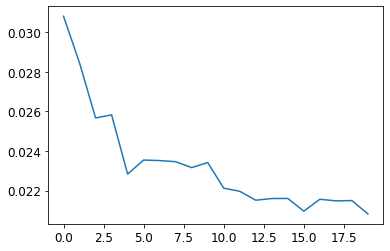

In [28]:
plt.plot(losses)
p

Compute scores of training data. 
* For each member_id, compute score for each destination. Rank destinations and compare against destinations actually travelled. 
* consider the 2016 data. For each user+user_attributes, cover a range of destinations. Each destination has its own destination attributes. 
Consider $n$ examples of destination attributes, compute a ranking of these $n$ items. There are 80 destinations and their attributes. Finally, 
there are attributes that are neither member destinations or desination attributes. 